# Azerbaijan GP

Major changes made:

- Dataset shift: change historical data to Baku-specific. (bias against rookies, can't be helped)
-  Normalisation of features for better correlation analysis
- Change of target variable: Average lap speed is a bad target variable given our dataset is vast and covers tracks other than Baku. For each track the avg lap speed is going to be different. [consider keeping if data has a bent towards Baku]
- Consider classification using XGBClassifier, figure out hyperparams to prevent overfitting (hyperops)
- OR regression using XGBoost on Baku data.
- Add Qualifying Time
- Add average of race pace in qualifying sessions instead of best pace.
- Convert podium predictor to string.

FINAL APPROACH:
- Classification on podium position using XGBClassifier/ Random Forest / LightGBM with hyperopt. Use imputation and normalisation


CHANGES MADE
- Minmax normalisation
- Driver encoding
- add downforce for tracks to account for speeds on straights and corners
- personal best race pace regardless of clean air

In [1]:
%pip install -q --upgrade numpy scikit-learn fastf1 keras xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import fastf1
import pandas as pd
fastf1.Cache.enable_cache("cache")

In [3]:
def get_weather_data(year,race,session):
    cur_session=fastf1.get_session(year,race,session)
    cur_session.load()
    weather_df=cur_session.weather_data
    weather_data={}
    weather_data["AirTemp"]=weather_df["AirTemp"].mean() # Average Air Temp in degrees Celsius
    weather_data["Humidity"]=weather_df["Humidity"].mean() # Average Humidity in % 
    weather_data["Pressure"]=weather_df["Pressure"].mean() # Average Air pressure in mbar
    weather_data["Rain"]=int(weather_df["Rainfall"].any()) # Check if there was any rainfall
    weather_data["WindSpeed"]=weather_df["WindSpeed"].mean() # Average Wind Speed in m/s
    weather_data["TrackTemp"]=weather_df["TrackTemp"].mean() # Average Track Temperature
    
    return weather_data

In [4]:
# We are not getting clean air race pace. We are getting the BEST pace from practice sessions. After talking to some people in the industry, I realised that
# the pace of the car in clean air might not be a very powerful predictive variable given that for most of the race the track WILL have other cars on it.

def get_best_race_pace(year, race):
    all_personal_bests = []
    
    for session in ["FP1", "FP2", "FP3"]:
        try:
            cur_session = fastf1.get_session(year, race, session)
            cur_session.load()
            laps = cur_session.laps
            
            laps = laps.drop(columns=['Time', 'DriverNumber', 'LapNumber', 'Stint',
            'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
            'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
            'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
            'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
            'LapStartDate', 'Position', 'DeletedReason',
            'FastF1Generated', 'IsAccurate'])
            # Note that while we are dropping DriverNumber, the 'Driver' column remaining contains abbreviations of the drivers for future mapping.

            laps = laps[(laps['Deleted']==False) & (laps.LapTime.notnull())]
            laps = laps.drop(columns=['Deleted','TrackStatus'])

            # Find Personal Best for this session
            personalbest = laps[laps['IsPersonalBest']==True].copy()
            if not personalbest.empty:
                personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
                personalbest = personalbest.drop(columns=['LapTime'])
                personalbest['Session'] = session  # Track which session
                all_personal_bests.append(personalbest)
                
        except Exception as e:
            print(f"Skipping {session} for {year} {race}: {e}")
            continue
    
    # Combine all sessions
    if all_personal_bests:
        combined_bests = pd.concat(all_personal_bests, ignore_index=True)
        
        # Find min lap time per driver across all sessions
        personalbest_map = combined_bests.loc[combined_bests.groupby('Driver')['LapTime (s)'].idxmin()]
        personalbest_map = personalbest_map.reset_index(drop=True)
        personalbest_map
        
        return personalbest_map
    else:
        return pd.DataFrame()  # Empty if no data found

In [5]:
"""
From categorise_by_downforce.py

track_downforce_mapping = {
    'Monaco': 'Very High DF',
    'Canada': 'High DF',
    'Silverstone': 'High DF',
    'Imola': 'High DF',
    'Hungary': 'Medium DF',
    'Australia': 'Medium DF',
    'Bahrain': 'Medium DF',
    'Austria': 'Medium DF',
    'Netherlands': 'Medium DF',
    'Spain': 'Low DF',
    'Japan': 'Low DF',
    'Saudi Arabia': 'Low DF',
    'Baku': 'Very Low DF',
    'Belgium': 'Very Low DF',
    'Miami': 'Very Low DF',
    'Monza': 'Very Low DF',
}


Numerical mapping:
downforce_numeric_mapping = {
    'Monaco': 5,
    'Canada': 4,
    'Silverstone': 4,
    'Imola': 4,
    'Hungary': 3,
    'Australia': 3,
    'Bahrain': 3,
    'Austria': 3,
    'Netherlands': 3,
    'Spain': 2,
    'Japan': 2,
    'Saudi Arabia': 2,
    'Baku': 1,
    'Belgium': 1,
    'Miami': 1,
    'Monza': 1,
}

"""


"\nFrom categorise_by_downforce.py\n\ntrack_downforce_mapping = {\n    'Monaco': 'Very High DF',\n    'Canada': 'High DF',\n    'Silverstone': 'High DF',\n    'Imola': 'High DF',\n    'Hungary': 'Medium DF',\n    'Australia': 'Medium DF',\n    'Bahrain': 'Medium DF',\n    'Austria': 'Medium DF',\n    'Netherlands': 'Medium DF',\n    'Spain': 'Low DF',\n    'Japan': 'Low DF',\n    'Saudi Arabia': 'Low DF',\n    'Baku': 'Very Low DF',\n    'Belgium': 'Very Low DF',\n    'Miami': 'Very Low DF',\n    'Monza': 'Very Low DF',\n}\n\n\nNumerical mapping:\ndownforce_numeric_mapping = {\n    'Monaco': 5,\n    'Canada': 4,\n    'Silverstone': 4,\n    'Imola': 4,\n    'Hungary': 3,\n    'Australia': 3,\n    'Bahrain': 3,\n    'Austria': 3,\n    'Netherlands': 3,\n    'Spain': 2,\n    'Japan': 2,\n    'Saudi Arabia': 2,\n    'Baku': 1,\n    'Belgium': 1,\n    'Miami': 1,\n    'Monza': 1,\n}\n\n"

In [6]:
# Build Model Train Data
# To be used for min-max normalization
from sklearn.preprocessing import MinMaxScaler
# To be used for Z-normalization (standardization)
from sklearn.preprocessing import StandardScaler
import logging

logging.getLogger('fastf1').setLevel(logging.ERROR)

train_sessions={2024:['Baku'],2025:['Australia','China','Japan','Bahrain','Saudi Arabia','Miami','Imola','Monaco','Spain','Canada','Austria','Silverstone','Belgium','Hungary','Netherlands','Monza']}
train_df=pd.DataFrame()
y=pd.DataFrame()

for year in train_sessions:
    for race in train_sessions[year]:
        cur_session=fastf1.get_session(year,race,'R')
        cur_session.load()
        print(f"--------------------------------------------------\nLoaded Data for {year} {race}\n--------------------------------------------------")
        cur_results=cur_session.results
        
        
        #-----------------DROP UNNECESSARY COLUMNS-----------------
        cur_results = cur_results.reset_index(drop=True)
        cur_results=cur_results.drop(columns=['DriverNumber', 'BroadcastName', 'DriverId', 'TeamName',
            'TeamColor', 'FirstName', 'LastName', 'FullName',
            'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
            'Q1', 'Q2', 'Q3', 'Status', 'Points'])
        #-----------------------------------------------------------
        
        cur_results.rename(columns={'Abbreviation':'Driver'},inplace=True)
        
        
        #------------------CALCULATE TOTAL RACETIME------------
        # Get winner's time in seconds
        cur_results.reset_index(drop=True,inplace=True)
        winner_time_seconds = cur_results.iloc[0]['Time'].total_seconds()

        cur_results['Time (s)'] = cur_results['Time'].dt.total_seconds()
        cur_results.loc[1:, 'Time (s)'] = winner_time_seconds + cur_results.loc[1:, 'Time (s)']

        #Winner
        cur_results.loc[0, 'Time (s)'] = winner_time_seconds

        cur_results['Time (s)'] = cur_results['Time (s)'].fillna(winner_time_seconds + 300)  # +5 minutes penalty
        #-------------------------------------------------------------
        
        
        #----------CALCULATE TOTAL LAP TIME BY SECTOR AVERAGE---------
        cur_laps = cur_session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
        cur_laps.dropna(inplace=True)

        # convert lap and sector times to seconds
        for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
            cur_laps[f"{col} (s)"] = cur_laps[col].dt.total_seconds()

        # aggregate sector times by driver
        sector_times = cur_laps.groupby("Driver").agg({
            "Sector1Time (s)": "mean",
            "Sector2Time (s)": "mean",
            "Sector3Time (s)": "mean"
        }).reset_index()

        sector_times["TotalSectorTime (s)"] = (
            sector_times["Sector1Time (s)"] +
            sector_times["Sector2Time (s)"] +
            sector_times["Sector3Time (s)"]
        )
        
        cur_results =  cur_results.merge(sector_times[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
        
        y = pd.concat([y,cur_laps.groupby("Driver")["LapTime (s)"].mean().reindex(cur_results["Driver"])])
        #-------------------------------------------------------------
        
        
        #----------------------FEATURE ENGINEERING--------------------
        cur_results['Grid_Gap_to_Pole'] = cur_results['GridPosition'] - cur_results['GridPosition'].min()
        
        # Calculate average qualifying position per team and subtract the drivers' quali positions from the mean.
        cur_results['Quali_vs_Teammate'] = cur_results.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

        cur_results['Race'] = race
        cur_results['Year'] = year
        #-------------------------------------------------------------
        
        
        #----------------------GET BEST RACE PACE----------------------
        # Get best track race pace among FP1, FP2 and FP3
        best_race_pace=get_best_race_pace(year,race)
        print("Got Best Race Pace")
        best_race_pace
        
        best_race_pace.drop(columns=['IsPersonalBest','Session'],inplace=True)
        pace_mapping=best_race_pace.set_index('Driver')['LapTime (s)']
        
        cur_results['Best_Pace_seconds'] = cur_results['Driver'].map(pace_mapping)
        #--------------------------------------------------------------
        
        
        #--------------------MORE FEATURE ENGINEERING------------------
        cur_results['Practice_Gap_to_Fastest'] = cur_results['Best_Pace_seconds'] - cur_results['Best_Pace_seconds'].min()

        cur_results['Practice_vs_Quali_Rank'] = cur_results['Best_Pace_seconds'].rank() - cur_results['GridPosition']

        cur_results['Quali_vs_Teammate'] = cur_results['Quali_vs_Teammate'].fillna(0)
        #--------------------------------------------------------------

        #------------------GET RACE DAY WEATHER DATA--------------------
        weather_data=get_weather_data(year,race,'R')
        cur_results = cur_results.assign(**weather_data)
        #---------------------------------------------------------------
        
        #---------------------------IS IT BAKU?-------------------------
        if race!='Baku':
            cur_results['Is_Baku']=0
        else:
            cur_results['Is_Baku']=1
        #---------------------------------------------------------------
        
        #-----------------------MAP DOWNFORCE LEVELS---------------------
        downforce_map={
            'Monaco': 5,
            'Canada': 4,
            'Silverstone': 4,
            'Imola': 4,
            'Hungary': 3,
            'Australia': 3,
            'Bahrain': 3,
            'Austria': 3,
            'Netherlands': 3,
            'Spain': 2,
            'Japan': 2,
            'Saudi Arabia': 2,
            'Baku': 1,
            'Belgium': 1,
            'Miami': 1,
            'Monza': 1
        }
        
        cur_results['Downforce_Level'] = cur_results['Race'].map(downforce_map)
        #------------------------------------------------------------------
        
        train_df = pd.concat([train_df, cur_results], ignore_index=True)      
        
        
 

--------------------------------------------------
Loaded Data for 2024 Baku
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Australia
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 China
--------------------------------------------------
Skipping FP2 for 2025 China: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 China: Session type 'FP3' does not exist for this event
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Japan
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Bahrain
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Saudi Arabia
--------------

In [7]:
train_df

,Driver,TeamId,GridPosition,Time,Laps,Time (s),TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,...,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Humidity,Pressure,Rain,WindSpeed,TrackTemp,Is_Baku,Downforce_Level
0,PIA,mclaren,2.0,0 days 01:32:58.007000,51.0,5578.007,108.403469,1.0,-6.5,Baku,...,0.235,2.0,26.705921,38.019737,1017.640132,0,1.551316,44.349342,1,1.0
1,LEC,ferrari,1.0,0 days 00:00:10.910000,51.0,5588.917,108.607878,0.0,-1.0,Baku,...,0.013,1.0,26.705921,38.019737,1017.640132,0,1.551316,44.349342,1,1.0
2,RUS,mercedes,5.0,0 days 00:00:31.328000,51.0,5609.335,108.979082,4.0,-7.0,Baku,...,0.000,-4.0,26.705921,38.019737,1017.640132,0,1.551316,44.349342,1,1.0
3,NOR,mclaren,15.0,0 days 00:00:36.143000,51.0,5614.150,108.943061,14.0,6.5,Baku,...,0.223,-12.0,26.705921,38.019737,1017.640132,0,1.551316,44.349342,1,1.0
4,VER,red_bull,6.0,0 days 00:01:17.098000,51.0,5655.105,108.929208,5.0,1.0,Baku,...,0.348,-1.0,26.705921,38.019737,1017.640132,0,1.551316,44.349342,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,GAS,alpine,20.0,0 days 00:00:05.837000,52.0,4410.162,84.597765,19.0,1.5,Monza,...,0.916,-1.5,26.761111,42.604167,996.752778,0,1.960417,43.288194,0,1.0
335,COL,alpine,17.0,0 days 00:00:07.448000,52.0,4411.773,84.655902,16.0,-1.5,Monza,...,0.703,-3.0,26.761111,42.604167,996.752778,0,1.960417,43.288194,0,1.0
336,STR,aston_martin,16.0,0 days 00:00:09.301000,52.0,4413.626,84.699804,15.0,4.0,Monza,...,0.916,2.5,26.761111,42.604167,996.752778,0,1.960417,43.288194,0,1.0
337,ALO,aston_martin,8.0,NaT,24.0,4704.325,86.602478,7.0,-4.0,Monza,...,0.530,4.0,26.761111,42.604167,996.752778,0,1.960417,43.288194,0,1.0


In [8]:
train_df.columns

Index(['Driver', 'TeamId', 'GridPosition', 'Time', 'Laps', 'Time (s)',
       'TotalSectorTime (s)', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Race',
       'Year', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Humidity', 'Pressure', 'Rain',
       'WindSpeed', 'TrackTemp', 'Is_Baku', 'Downforce_Level'],
      dtype='object')

In [9]:
#Drop Time, Laps, Time (s)

train_df.drop(columns=['Time', 'Laps', 'Time (s)'],inplace=True)
train_df

,Driver,TeamId,GridPosition,TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Humidity,Pressure,Rain,WindSpeed,TrackTemp,Is_Baku,Downforce_Level
0,PIA,mclaren,2.0,108.403469,1.0,-6.5,Baku,2024,102.749,0.235,2.0,26.705921,38.019737,1017.640132,0,1.551316,44.349342,1,1.0
1,LEC,ferrari,1.0,108.607878,0.0,-1.0,Baku,2024,102.527,0.013,1.0,26.705921,38.019737,1017.640132,0,1.551316,44.349342,1,1.0
2,RUS,mercedes,5.0,108.979082,4.0,-7.0,Baku,2024,102.514,0.000,-4.0,26.705921,38.019737,1017.640132,0,1.551316,44.349342,1,1.0
3,NOR,mclaren,15.0,108.943061,14.0,6.5,Baku,2024,102.737,0.223,-12.0,26.705921,38.019737,1017.640132,0,1.551316,44.349342,1,1.0
4,VER,red_bull,6.0,108.929208,5.0,1.0,Baku,2024,102.862,0.348,-1.0,26.705921,38.019737,1017.640132,0,1.551316,44.349342,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,GAS,alpine,20.0,84.597765,19.0,1.5,Monza,2025,80.247,0.916,-1.5,26.761111,42.604167,996.752778,0,1.960417,43.288194,0,1.0
335,COL,alpine,17.0,84.655902,16.0,-1.5,Monza,2025,80.034,0.703,-3.0,26.761111,42.604167,996.752778,0,1.960417,43.288194,0,1.0
336,STR,aston_martin,16.0,84.699804,15.0,4.0,Monza,2025,80.247,0.916,2.5,26.761111,42.604167,996.752778,0,1.960417,43.288194,0,1.0
337,ALO,aston_martin,8.0,86.602478,7.0,-4.0,Monza,2025,79.861,0.530,4.0,26.761111,42.604167,996.752778,0,1.960417,43.288194,0,1.0


In [10]:
train_df.drop(columns=['Humidity'],inplace=True)
train_df

,Driver,TeamId,GridPosition,TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Baku,Downforce_Level
0,PIA,mclaren,2.0,108.403469,1.0,-6.5,Baku,2024,102.749,0.235,2.0,26.705921,1017.640132,0,1.551316,44.349342,1,1.0
1,LEC,ferrari,1.0,108.607878,0.0,-1.0,Baku,2024,102.527,0.013,1.0,26.705921,1017.640132,0,1.551316,44.349342,1,1.0
2,RUS,mercedes,5.0,108.979082,4.0,-7.0,Baku,2024,102.514,0.000,-4.0,26.705921,1017.640132,0,1.551316,44.349342,1,1.0
3,NOR,mclaren,15.0,108.943061,14.0,6.5,Baku,2024,102.737,0.223,-12.0,26.705921,1017.640132,0,1.551316,44.349342,1,1.0
4,VER,red_bull,6.0,108.929208,5.0,1.0,Baku,2024,102.862,0.348,-1.0,26.705921,1017.640132,0,1.551316,44.349342,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,GAS,alpine,20.0,84.597765,19.0,1.5,Monza,2025,80.247,0.916,-1.5,26.761111,996.752778,0,1.960417,43.288194,0,1.0
335,COL,alpine,17.0,84.655902,16.0,-1.5,Monza,2025,80.034,0.703,-3.0,26.761111,996.752778,0,1.960417,43.288194,0,1.0
336,STR,aston_martin,16.0,84.699804,15.0,4.0,Monza,2025,80.247,0.916,2.5,26.761111,996.752778,0,1.960417,43.288194,0,1.0
337,ALO,aston_martin,8.0,86.602478,7.0,-4.0,Monza,2025,79.861,0.530,4.0,26.761111,996.752778,0,1.960417,43.288194,0,1.0


In [11]:
train_df.dtypes

Driver                      object
TeamId                      object
GridPosition               float64
TotalSectorTime (s)        float64
Grid_Gap_to_Pole           float64
Quali_vs_Teammate          float64
Race                        object
Year                         int64
Best_Pace_seconds          float64
Practice_Gap_to_Fastest    float64
Practice_vs_Quali_Rank     float64
AirTemp                    float64
Pressure                   float64
Rain                         int64
WindSpeed                  float64
TrackTemp                  float64
Is_Baku                      int64
Downforce_Level            float64
dtype: object

In [12]:
y


,LapTime (s)
PIA,108.403469
LEC,108.607878
RUS,108.979082
NOR,108.943061
VER,108.929208
...,...
GAS,84.597765
COL,84.655902
STR,84.699804
ALO,86.602478


In [13]:
train_df.to_csv("../data/train_df_baku.csv")

FINAL TRAINING DATA

Original shape: X(339, 17), y(339, 1)
After cleaning: X(327, 17), y(327, 1)
Debug info:
drivers_test shape: (82,)
drivers_test type: <class 'pandas.core.series.Series'>
lr_test_pred shape: (82, 1)
lr_test_pred type: <class 'numpy.ndarray'>
y_test shape: (82, 1)
y_test type: <class 'pandas.core.frame.DataFrame'>
drivers_test length: 82
lr_test_pred length: 82
y_test length: 82

=== LINEAR REGRESSION ===
Training MAE: 2.116 seconds
Test MAE: 2.182 seconds
Test R²: 0.925

=== RIDGE REGRESSION ===
Training MAE: 3.229 seconds
Test MAE: 3.223 seconds
Test R²: 0.876
X COLUMNS:  Index(['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate',
       'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed',
       'TrackTemp', 'Is_Baku', 'Downforce_Level', 'TeamId_encoded',
       'Race_encoded', 'Year_encoded', 'Driver_encoded'],
      dtype='object')
COEFS :  [  2.17908936   2.17908936  -1.60822929  37.2274

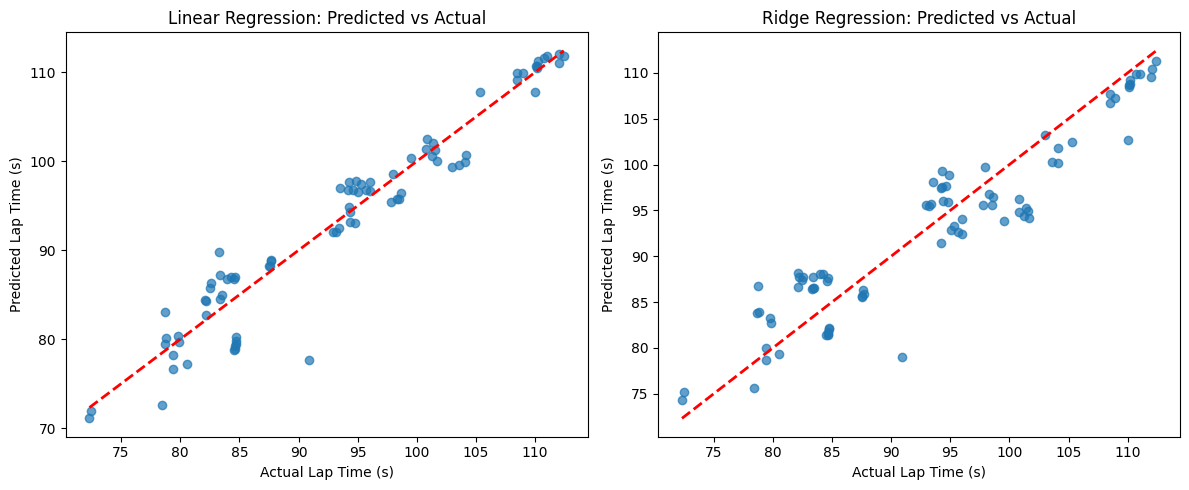


Overfitting Analysis:
Linear Regression gap: 0.066 seconds
Ridge Regression gap: -0.006 seconds


In [14]:
# TRAIN THE MODEL 
# I am using simpler regression models here because earlier tests with XGBoost and ANNs led to severe overfitting due to the lack of data (we only have 80 rows)
# Of course with time there is the option of...drumroll...getting MORE data. But due to time constraints this is what we have to work with.

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

drivers = train_df['Driver'].copy()

# Encode categoricals
le_team = LabelEncoder()
le_race = LabelEncoder()
le_year=LabelEncoder()
le_driver = LabelEncoder()

train_df['TeamId_encoded'] = le_team.fit_transform(train_df['TeamId'])
train_df['Race_encoded'] = le_race.fit_transform(train_df['Race'])
train_df['Year_encoded'] = le_year.fit_transform(train_df['Year'])
train_df['Driver_encoded'] = le_driver.fit_transform(train_df['Driver'])

X_init = train_df.drop(columns=['Driver', 'TeamId', 'Race', 'TotalSectorTime (s)','Year'])
X_init = X_init.fillna(0)

# Define categorical columns that should NOT be normalized
categorical_columns = ['Year_encoded','Driver_encoded', 'Is_Baku', 'Downforce_Level', 'TeamId_encoded', 'Race_encoded','Rain']

# Identify columns to normalize
continuous_columns = [col for col in X_init.columns if col not in categorical_columns]

# Fit min-max scaler only on continuous columns
norm = MinMaxScaler().fit(X_init[continuous_columns])

# Create normalized dataset
X_normalized = X_init.copy()
X_normalized[continuous_columns] = norm.transform(X_init[continuous_columns])

print("FINAL TRAINING DATA\n")
X = X_normalized

X = pd.DataFrame(X, columns=X_init.columns)

# Reset indices to ensure alignment
X_reset = X.reset_index(drop=True)
y_reset = y.reset_index(drop=True) 
drivers_reset = drivers.reset_index(drop=True)

# Now create the boolean mask
valid_indices = y_reset.notna().squeeze()

# Apply the mask
X_clean = X_reset[valid_indices]
y_clean = y_reset[valid_indices]  
drivers_clean = drivers_reset[valid_indices]

print(f"Original shape: X{X_reset.shape}, y{y_reset.shape}")
print(f"After cleaning: X{X_clean.shape}, y{y_clean.shape}")

# Now use the cleaned data for train_test_split
X_train, X_test, y_train, y_test, drivers_train, drivers_test = train_test_split(
    X_clean, y_clean, drivers_clean, test_size=0.25, random_state=42
)

# print(" Y TRAIN : ",y_train)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

ridge_model = Ridge(alpha=5.0) # Increased regularisation to prevent overfitting (from a lot of trial runs...)
ridge_model.fit(X_train, y_train)

lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred = ridge_model.predict(X_test)

# Debug the array shapes
print("Debug info:")
print(f"drivers_test shape: {drivers_test.shape}")
print(f"drivers_test type: {type(drivers_test)}")
print(f"lr_test_pred shape: {lr_test_pred.shape}")
print(f"lr_test_pred type: {type(lr_test_pred)}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test type: {type(y_test)}")

# Check if they're all the same length
print(f"drivers_test length: {len(drivers_test)}")
print(f"lr_test_pred length: {len(lr_test_pred)}")
print(f"y_test length: {len(y_test)}")

# Evaluate models
print("\n=== LINEAR REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, lr_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, lr_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, lr_test_pred):.3f}")

print("\n=== RIDGE REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, ridge_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, ridge_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, ridge_test_pred):.3f}")

print("X COLUMNS: ",X.columns)
print("COEFS : ",lr_model.coef_[0])
# Feature importance 
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (Linear Regression):")
print(feature_importance.head(10))

# Convert everything to 1D numpy arrays
drivers_array = np.array(drivers_test).flatten()
pred_array = np.array(lr_test_pred).flatten()
actual_array = np.array(y_test).flatten()

test_results = pd.DataFrame({
    'Driver': drivers_array,
    'Predicted_LapTime': pred_array,
    'Actual_LapTime': actual_array
}).sort_values('Predicted_LapTime')

print("\nPredicted Fastest 3 Drivers (Test Set):")
print(test_results.head(3))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Linear Regression: Predicted vs Actual')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Ridge Regression: Predicted vs Actual')

plt.tight_layout()
plt.show()

# Check overfitting
overfitting_gap_lr = mean_absolute_error(y_test, lr_test_pred) - mean_absolute_error(y_train, lr_train_pred)
overfitting_gap_ridge = mean_absolute_error(y_test, ridge_test_pred) - mean_absolute_error(y_train, ridge_train_pred)

print(f"\nOverfitting Analysis:")
print(f"Linear Regression gap: {overfitting_gap_lr:.3f} seconds")
print(f"Ridge Regression gap: {overfitting_gap_ridge:.3f} seconds")

In [15]:
# Check correlation between features and target
correlations = X_clean.corrwith(y_clean.squeeze()).abs().sort_values(ascending=False)
print("Feature correlations with target:")
print(correlations.head(10))

# Check for perfect correlations (1.0)
perfect_corr = correlations[correlations > 0.99]
print(f"\nFeatures with correlation > 0.99:")
print(perfect_corr)

Feature correlations with target:
Best_Pace_seconds          0.854943
TrackTemp                  0.547806
Downforce_Level            0.407491
Rain                       0.382358
Is_Baku                    0.377420
Year_encoded               0.377420
AirTemp                    0.309504
Race_encoded               0.193199
Practice_Gap_to_Fastest    0.147583
Pressure                   0.061771
dtype: float64

Features with correlation > 0.99:
Series([], dtype: float64)


In [16]:
X

,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Baku,Downforce_Level,TeamId_encoded,Race_encoded,Year_encoded,Driver_encoded
0,0.052632,0.052632,0.138889,0.926216,0.069301,0.576923,0.771206,0.982959,0,0.229152,0.838213,1,1.0,4,3,0,17
1,0.000000,0.000000,0.444444,0.920865,0.003834,0.538462,0.771206,0.982959,0,0.229152,0.838213,1,1.0,2,3,0,13
2,0.210526,0.210526,0.111111,0.920552,0.000000,0.346154,0.771206,0.982959,0,0.229152,0.838213,1,1.0,5,3,0,19
3,0.736842,0.736842,0.861111,0.925927,0.065762,0.038462,0.771206,0.982959,0,0.229152,0.838213,1,1.0,4,3,0,14
4,0.263158,0.263158,0.555556,0.928940,0.102625,0.461538,0.771206,0.982959,0,0.229152,0.838213,1,1.0,7,3,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,1.000000,1.000000,0.583333,0.383816,0.270127,0.442308,0.774673,0.706611,0,0.393060,0.803205,0,1.0,0,12,1,8
335,0.842105,0.842105,0.416667,0.378682,0.207313,0.384615,0.774673,0.706611,0,0.393060,0.803205,0,1.0,0,12,1,6
336,0.789474,0.789474,0.722222,0.383816,0.270127,0.596154,0.774673,0.706611,0,0.393060,0.803205,0,1.0,1,12,1,21
337,0.368421,0.368421,0.277778,0.374512,0.156296,0.653846,0.774673,0.706611,0,0.393060,0.803205,0,1.0,1,12,1,1


In [17]:
X.columns

Index(['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate',
       'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed',
       'TrackTemp', 'Is_Baku', 'Downforce_Level', 'TeamId_encoded',
       'Race_encoded', 'Year_encoded', 'Driver_encoded'],
      dtype='object')

In [37]:

#----------------CREATE PREDICTION DATASET-----------------

predict_df = pd.DataFrame()
predict_df['Abbreviation'] = ['PIA','NOR','HAM','LEC','RUS','ANT','LAW','HAD','SAI','ALB','VER','TSU','ALO','STR','BEA','OCO','BOR','HUL','GAS','COL']

# Create driver to team mapping (2025 season)
driver_to_team = {
    'PIA': 'mclaren',
    'NOR': 'mclaren', 
    'HAM': 'ferrari',       
    'LEC': 'ferrari',
    'RUS': 'mercedes',
    'ANT': 'mercedes',      
    'LAW': 'rb',           
    'HAD': 'rb',
    'SAI': 'williams',       
    'ALB': 'williams',
    'VER': 'red_bull',
    'TSU': 'red_bull',           
    'ALO': 'aston_martin',
    'STR': 'aston_martin',
    'BEA': 'haas',          
    'OCO': 'haas',
    'BOR': 'sauber',       
    'HUL': 'sauber',
    'GAS': 'alpine',
    'COL': 'alpine'    
}

predict_df['TeamId'] = predict_df['Abbreviation'].map(driver_to_team)

grid_positions = {
    'VER': 1.0,
    'SAI': 2.0, 
    'LAW': 3.0,
    'ANT': 4.0,
    'RUS': 5.0,
    'TSU': 6.0,       
    'NOR': 7.0,          
    'HAD': 8.0,
    'PIA': 9.0,    
    'LEC': 10.0,
    'ALO': 11.0,            
    'HAM': 12.0,
    'BOR': 13.0,
    'STR': 14.0,          
    'BEA': 15.0,
    'COL': 16.0,       
    'HUL': 17.0,
    'OCO': 18.0,
    'GAS': 19.0,  
    'ALB': 20.0
}

predict_df['GridPosition'] = predict_df['Abbreviation'].map(grid_positions)
predict_df['Grid_Gap_to_Pole'] = predict_df['GridPosition'] - predict_df['GridPosition'].min()
predict_df['Quali_vs_Teammate'] = predict_df.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

predict_df['Race'] = 'Baku'
predict_df['Year'] = 2025

# Encode categorical variables using the same encoders from training
predict_df['Race_encoded'] = le_race.transform(predict_df['Race'])
predict_df['TeamId_encoded'] = le_team.transform(predict_df['TeamId'])
predict_df['Year_encoded'] = le_year.transform(predict_df['Year'])
predict_df['Driver_encoded'] = le_driver.transform(predict_df['Abbreviation'])

predict_df['Is_Baku'] = 1

# Add Downforce Level (Baku is low downforce = 1)
predict_df['Downforce_Level'] = 1

# Get practice pace data
best_race_pace = get_best_race_pace(2025, 'Baku')
best_race_pace.drop(columns=['IsPersonalBest','Session'], inplace=True)
pace_mapping = best_race_pace.set_index('Driver')['LapTime (s)']
predict_df['Best_Pace_seconds'] = predict_df['Abbreviation'].map(pace_mapping)
        
predict_df['Practice_Gap_to_Fastest'] = predict_df['Best_Pace_seconds'] - predict_df['Best_Pace_seconds'].min()
predict_df['Practice_vs_Quali_Rank'] = predict_df['Best_Pace_seconds'].rank() - predict_df['GridPosition']
predict_df['Quali_vs_Teammate'] = predict_df['Quali_vs_Teammate'].fillna(0)

# Weather data (predicted for race day)
predict_df['Rain'] = 0
predict_df['AirTemp'] = 21.000000
predict_df['TrackTemp'] = 20.000000
predict_df['Pressure'] = 1021.000000
predict_df['WindSpeed'] = 13.055600

# Drop original categorical columns (keep only encoded versions)
predict_df.drop(columns=['TeamId', 'Race','Year'], inplace=True)

# Rename Driver column to match training data
predict_df.rename(columns={'Abbreviation': 'Driver'}, inplace=True)

# Create final prediction features (same structure as training)
X_predict = predict_df.drop(columns=['Driver'])
X_predict = X_predict.fillna(0)

# CRITICAL FIX: Reorder columns to match EXACTLY what the training data had
# Get the exact column order from the training data
training_columns = X_clean.columns.tolist()
print("Training columns order:", training_columns)

# Reorder prediction data to match training data exactly
X_predict = X_predict[training_columns]

print("Prediction columns order:", X_predict.columns.tolist())
print("Columns match:", list(X_predict.columns) == training_columns)

# Apply the same normalization as training data
categorical_columns = ['Year_encoded', 'Driver_encoded', 'Is_Baku', 'Downforce_Level', 'TeamId_encoded', 'Race_encoded', 'Rain']
continuous_columns = [col for col in X_predict.columns if col not in categorical_columns]

print("Continuous columns for normalization:", continuous_columns)

# Normalize only continuous columns using the same scaler fitted on training data
X_predict_normalized = X_predict.copy()
X_predict_normalized[continuous_columns] = norm.transform(X_predict[continuous_columns])

print("Prediction dataset shape:", X_predict_normalized.shape)
print("Training dataset shape:", X.shape)

Training columns order: ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed', 'TrackTemp', 'Is_Baku', 'Downforce_Level', 'TeamId_encoded', 'Race_encoded', 'Year_encoded', 'Driver_encoded']
Prediction columns order: ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed', 'TrackTemp', 'Is_Baku', 'Downforce_Level', 'TeamId_encoded', 'Race_encoded', 'Year_encoded', 'Driver_encoded']
Columns match: True
Continuous columns for normalization: ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'WindSpeed', 'TrackTemp']
Prediction dataset shape: (20, 17)
Training dataset shape: (339, 17)


In [38]:
X_predict_normalized.columns

Index(['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate',
       'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed',
       'TrackTemp', 'Is_Baku', 'Downforce_Level', 'TeamId_encoded',
       'Race_encoded', 'Year_encoded', 'Driver_encoded'],
      dtype='object')

In [39]:
X_predict_normalized

,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Baku,Downforce_Level,TeamId_encoded,Race_encoded,Year_encoded,Driver_encoded
0,0.421053,0.421053,0.555556,0.895555,0.074904,0.346154,0.412745,1.027412,0,4.838414,0.0349,1,1,4,3,1,17
1,0.315789,0.315789,0.444444,0.889433,0.000000,0.269231,0.412745,1.027412,0,4.838414,0.0349,1,1,4,3,1,14
2,0.578947,0.578947,0.555556,0.891120,0.020643,0.115385,0.412745,1.027412,0,4.838414,0.0349,1,1,2,3,1,10
3,0.473684,0.473684,0.444444,0.892904,0.042465,0.230769,0.412745,1.027412,0,4.838414,0.0349,1,1,2,3,1,13
4,0.210526,0.210526,0.527778,0.902618,0.161309,0.538462,0.412745,1.027412,0,4.838414,0.0349,1,1,5,3,1,19
5,0.157895,0.157895,0.472222,0.902835,0.163963,0.615385,0.412745,1.027412,0,4.838414,0.0349,1,1,5,3,1,2
6,0.105263,0.105263,0.361111,0.907897,0.225892,0.769231,0.412745,1.027412,0,4.838414,0.0349,1,1,6,3,1,12
7,0.368421,0.368421,0.638889,0.914598,0.307874,0.692308,0.412745,1.027412,0,4.838414,0.0349,1,1,6,3,1,9
8,0.052632,0.052632,0.000000,0.914308,0.304335,0.884615,0.412745,1.027412,0,4.838414,0.0349,1,1,9,3,1,20
9,1.000000,1.000000,1.000000,0.907752,0.224123,0.076923,0.412745,1.027412,0,4.838414,0.0349,1,1,9,3,1,0


In [40]:
predict_df['Driver']

0     PIA
1     NOR
2     HAM
3     LEC
4     RUS
5     ANT
6     LAW
7     HAD
8     SAI
9     ALB
10    VER
11    TSU
12    ALO
13    STR
14    BEA
15    OCO
16    BOR
17    HUL
18    GAS
19    COL
Name: Driver, dtype: object

In [57]:
#Make Predictions
predicted_lap_times = lr_model.predict(X_predict_normalized)

print("PREDICTIONS")
# print(predicted_lap_times)

results_df = pd.DataFrame({
    'Driver': predict_df['Driver'],
    'Predicted_LapTime': predicted_lap_times.flatten()
}).sort_values('Predicted_LapTime')

# Get top 3 fastest 
print("\nPREDICTED 2025 BAKU PODIUM")
print("===============================")
print(f"🥇 P1: {results_df.iloc[0]['Driver']} - {results_df.iloc[0]['Predicted_LapTime']}s")
print(f"🥈 P2: {results_df.iloc[1]['Driver']} - {results_df.iloc[1]['Predicted_LapTime']}s") 
print(f"🥉 P3: {results_df.iloc[2]['Driver']} - {results_df.iloc[2]['Predicted_LapTime']}s")

print("\nFull Results:")
results_df.reset_index(drop=True, inplace=True)
print(results_df.head(20))

PREDICTIONS

PREDICTED 2025 BAKU PODIUM
🥇 P1: VER - 159.8413476274081s
🥈 P2: RUS - 159.87881427279484s
🥉 P3: TSU - 160.2164683200188s

Full Results:
   Driver  Predicted_LapTime
0     VER         159.841348
1     RUS         159.878814
2     TSU         160.216468
3     NOR         160.309607
4     PIA         160.433510
5     LEC         160.619730
6     LAW         160.629583
7     HAM         160.693093
8     ANT         160.749870
9     HAD         160.834510
10    SAI         160.889636
11    STR         160.906178
12    OCO         161.216420
13    ALB         161.618731
14    HUL         161.622589
15    BEA         161.654624
16    ALO         161.716211
17    GAS         161.829468
18    BOR         162.057952
19    COL         162.067621


In [48]:
lr_model.score(X_test,y_test)

0.9250395104248939

In [52]:
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_.flatten(),
    'Abs_Coefficient': abs(lr_model.coef_.flatten())
}).sort_values('Abs_Coefficient', ascending=False)

print(coefs.head(20))

                    Feature  Coefficient  Abs_Coefficient
3         Best_Pace_seconds    37.227407        37.227407
10                TrackTemp   -16.478718        16.478718
6                   AirTemp    12.325208        12.325208
9                 WindSpeed    10.543226        10.543226
8                      Rain     8.461025         8.461025
4   Practice_Gap_to_Fastest    -7.194922         7.194922
15             Year_encoded    -5.671164         5.671164
11                  Is_Baku     5.671164         5.671164
5    Practice_vs_Quali_Rank     3.704114         3.704114
7                  Pressure    -2.812392         2.812392
0              GridPosition     2.179089         2.179089
1          Grid_Gap_to_Pole     2.179089         2.179089
12          Downforce_Level     1.955586         1.955586
2         Quali_vs_Teammate    -1.608229         1.608229
14             Race_encoded     0.457343         0.457343
13           TeamId_encoded     0.051295         0.051295
16           D

In [54]:
coefs.sort_values(by='Coefficient',ascending=False)

,Feature,Coefficient,Abs_Coefficient
3,Best_Pace_seconds,37.227407,37.227407
6,AirTemp,12.325208,12.325208
9,WindSpeed,10.543226,10.543226
8,Rain,8.461025,8.461025
11,Is_Baku,5.671164,5.671164
5,Practice_vs_Quali_Rank,3.704114,3.704114
0,GridPosition,2.179089,2.179089
1,Grid_Gap_to_Pole,2.179089,2.179089
12,Downforce_Level,1.955586,1.955586
14,Race_encoded,0.457343,0.457343
